<a href="https://colab.research.google.com/github/palver7/deeplearning/blob/master/FashionMNIST_with_ResNet50_no_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from torchvision.datasets import FashionMNIST
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import random_split,DataLoader
import os
import copy

plt.ion()

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
samples = 64 #num of sample per batch
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(224),
        transforms.Grayscale(3),
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

trainset = FashionMNIST(root='./data', train=True, 
                        download=True, transform=data_transforms['train'])

trainset, valset = random_split(trainset, (50000,10000))

trainloader = DataLoader(trainset, batch_size=samples, shuffle=True, 
                                          num_workers=4)

testset = FashionMNIST(root='./data', train=False, 
                       download=True,transform=data_transforms['test'])

testloader = DataLoader(testset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

valloader = DataLoader(valset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {'train': trainloader, 'val': valloader, 'test': testloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

 Coat  Coat Sandal   Bag   Bag Dress T-shirt/top Trouser


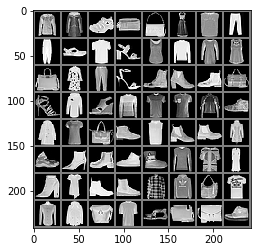

In [6]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [0]:
def train_model(model, criterion, optimizer, scheduler, val_acc, 
                val_loss, train_acc, train_loss, epoch,
                num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    list = {'train': {'acc': train_acc, 'loss': train_loss}, 
        'val':{'acc': val_acc, 'loss': val_loss}}
    next = epoch
    for epoch in range(next, next + num_epochs):
        print('Epoch {}/{}'.format(epoch, next + num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        
            running_loss = 0.0
            running_corrects = 0
        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()
        
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            list[phase]['loss'].append(epoch_loss)
            list[phase]['acc'].append(epoch_acc.item())
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
        
    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, epoch + 1

In [9]:
model = models.resnet50(pretrained=True)
#for param in model.parameters():
#    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 150995521.45it/s]


In [0]:
# Lists for plotting loss and accuracy and variable to keep track of epochs.
# Rerun this cell if you want to restart training to empty the lists.
epoch = 0
val_acc = []
val_loss = []
train_acc = []
train_loss = []

In [11]:
model, epoch = train_model(model, criterion, optimizer, scheduler, val_acc, val_loss, 
                    train_acc, train_loss, epoch, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.4593 Acc: 0.8415
val Loss: 0.2828 Acc: 0.8966

Epoch 1/19
----------
train Loss: 0.2639 Acc: 0.9045
val Loss: 0.2395 Acc: 0.9126

Epoch 2/19
----------
train Loss: 0.2175 Acc: 0.9210
val Loss: 0.2342 Acc: 0.9151

Epoch 3/19
----------
train Loss: 0.1875 Acc: 0.9306
val Loss: 0.2239 Acc: 0.9173

Epoch 4/19
----------
train Loss: 0.1639 Acc: 0.9410
val Loss: 0.2162 Acc: 0.9246

Epoch 5/19
----------
train Loss: 0.1471 Acc: 0.9465
val Loss: 0.2249 Acc: 0.9224

Epoch 6/19
----------
train Loss: 0.1067 Acc: 0.9617
val Loss: 0.2112 Acc: 0.9270

Epoch 7/19
----------
train Loss: 0.0930 Acc: 0.9669
val Loss: 0.2116 Acc: 0.9289

Epoch 8/19
----------
train Loss: 0.0851 Acc: 0.9691
val Loss: 0.2160 Acc: 0.9265

Epoch 9/19
----------
train Loss: 0.0797 Acc: 0.9714
val Loss: 0.2146 Acc: 0.9293

Epoch 10/19
----------
train Loss: 0.0764 Acc: 0.9734
val Loss: 0.2263 Acc: 0.9280

Epoch 11/19
----------
train Loss: 0.0701 Acc: 0.9745
val Loss: 0.2261 Acc: 0.9298

Ep

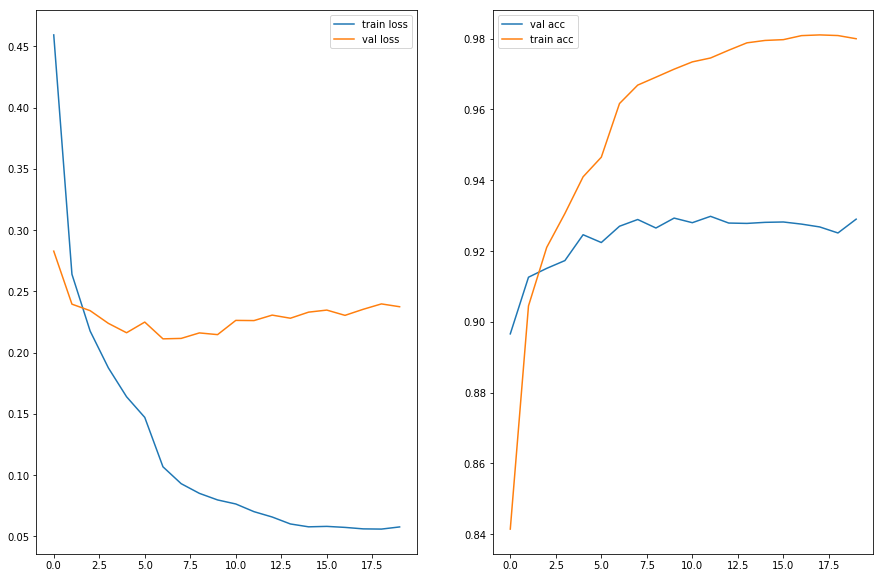

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(train_loss, label='train loss')
ax1.plot(val_loss, label='val loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(val_acc, label='val acc')
ax2.plot(train_acc, label='train acc')
ax2.legend()

GroundTruth:  Ankle Boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt


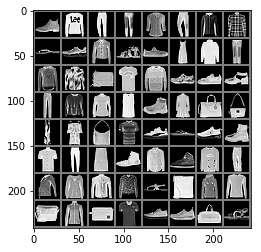

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] \
                                for j in range(8)))

Predicted:  Ankle Boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt


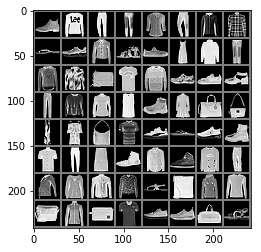

In [14]:
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
imshow(torchvision.utils.make_grid(images.cpu()))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] \
                              for j in range(8)))

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on the test images : %.4f' %
     (correct/total))

Accuracy of the network on the test images : 0.9217


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
      
for i in range(10):
    print('Accuracy of %5s : %.4f' % 
         (classes[i], class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 0.9091
Accuracy of Trouser : 0.9762
Accuracy of Pullover : 0.9222
Accuracy of Dress : 0.8606
Accuracy of  Coat : 0.8487
Accuracy of Sandal : 0.9867
Accuracy of Shirt : 0.7410
Accuracy of Sneaker : 0.9810
Accuracy of   Bag : 0.9801
Accuracy of Ankle Boot : 0.9800


Comparing training and validation accuracy and the training time of feature extraction (freezing the backpropagation) and  finetuning the model (use pretrained model, not freezing the backpropagation)

###the feature extraction results are (5 epochs, 224 x 224 pixels):
Training complete in 73m 54s
Best val Acc: 0.827600

### the finetuning results are (20 epochs 28 x 28 pixels):
Training complete in 19m 18s
Best val Acc: 0.929800

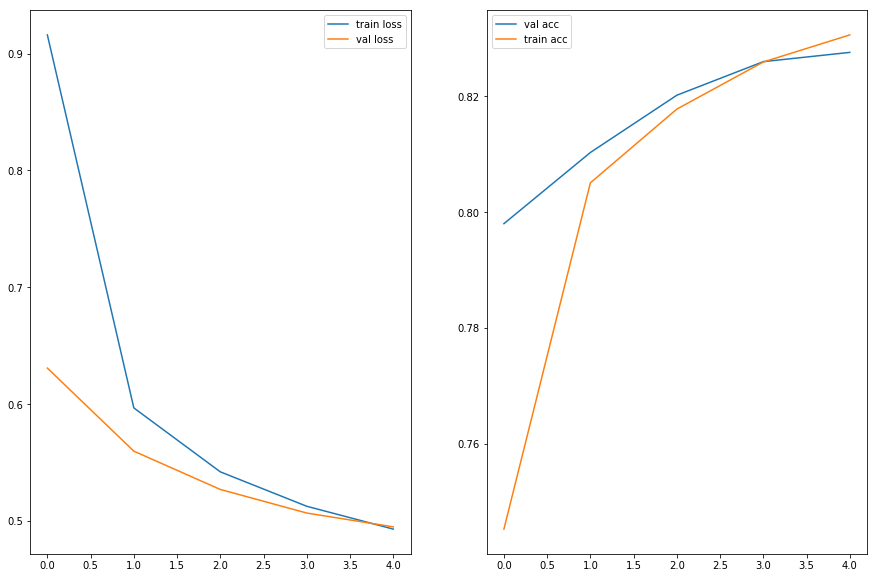

Result of transfer learning with frozen backpropagation using ResNet50.

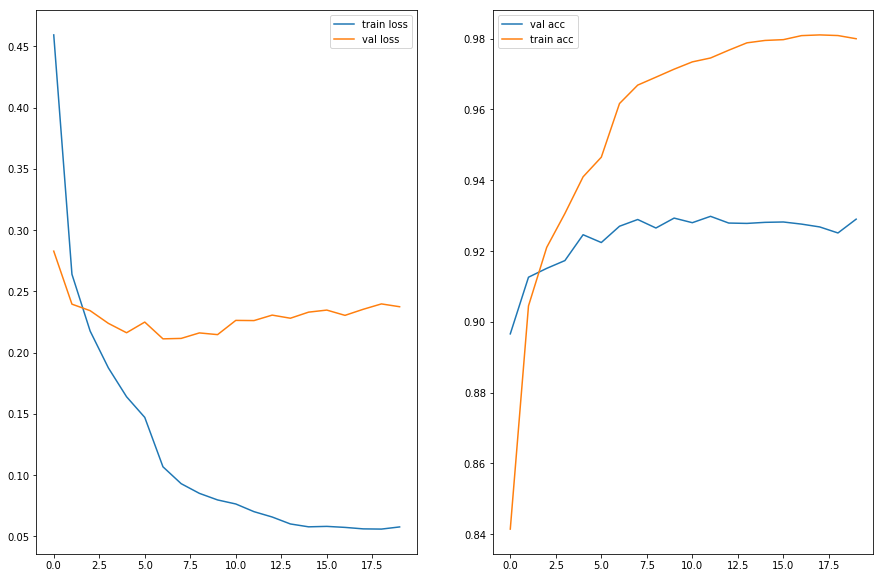

Result of finetuning pretrained model after 20 epochs and 28 x 28 pixel images.

In [0]:
torch.save({'epoch' : epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss, 'val_loss': val_loss, 
            'train_acc': train_acc, 'val_acc': val_acc}, 
           './FMNIST_ResNet50_noresize.tar')

In [0]:
checkpoint = torch.load('./FMNIST_ResNet18_noresize.tar')
model.load_state_dict(checkpoint['model_state_dict'])  
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']
val_loss = checkpoint['val_loss']
val_acc = checkpoint['val_acc']
epoch = checkpoint['epoch']